# References
* Most cells that required me to reference course material to obtain correct code for usage will have a comment inside.
  * Each will directly reference a certain module, day, and activity.
  * For example, `"Ref: 8.1.1"` equates to `"Module 8`, `Day 1`, `Activity #1"`.
* All other references will be numbered and correspond to the numbered links in my `"References"` portion of the `README.md` file.
  * For example, "Ref #5" would reference my #4 reference listed in the README.md file, which provides a link to the Pandas documentation I viewed.


# Forecasting Net Prophet

You’re a growth analyst at [MercadoLibre](http://investor.mercadolibre.com/about-us). With over 200 million users, MercadoLibre is the most popular e-commerce site in Latin America. You've been tasked with analyzing the company's financial and user data in clever ways to make the company grow. So, you want to find out if the ability to predict search traffic can translate into the ability to successfully trade the stock.

The instructions for this Challenge are divided into four steps, as follows:

* Step 1: Find unusual patterns in hourly Google search traffic

* Step 2: Mine the search traffic data for seasonality

* Step 3: Relate the search traffic to stock price patterns

* Step 4: Create a time series model with Prophet

The following subsections detail these steps.

## Install and import the required libraries and dependencies

In [1]:
# Install the required libraries
!pip install prophet

In [2]:
# Import the required libraries and dependencies
import pandas as pd
from prophet import Prophet
import datetime as dt
import numpy as np
%matplotlib inline
from google.colab import files

## Step 1: Find Unusual Patterns in Hourly Google Search Traffic

The data science manager asks if the Google search traffic for the company links to any financial events at the company. Or, does the search traffic data just present random noise? To answer this question, pick out any unusual patterns in the Google search data for the company, and connect them to the corporate financial events.

To do so, complete the following steps:

1. Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

2. Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?


#### Step 1: Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

**Question**: Do any unusual patterns exist?
### **Answer**:
* It appears that search trends in the month of May 2020 had spikes between the 4th and 5th. The rest of the plot follows a similar pattern, where it rises and falls every 3-4 days.

In [3]:
# Store the data in a Pandas DataFrame
# Set the "Date" column as the Datetime Index.

df_mercado_trends = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/google_hourly_search_trends.csv",
    index_col='Date',
    parse_dates=True
).dropna()

# Review the first and last five rows of the DataFrame
display(df_mercado_trends.head())
display(df_mercado_trends.tail())

<ipython-input-3-217fb1a948ac>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_mercado_trends = pd.read_csv(


,Search Trends
Date,
2016-06-01 00:00:00,97
2016-06-01 01:00:00,92
2016-06-01 02:00:00,76
2016-06-01 03:00:00,60
2016-06-01 04:00:00,38


,Search Trends
Date,
2020-09-07 20:00:00,71
2020-09-07 21:00:00,83
2020-09-07 22:00:00,96
2020-09-07 23:00:00,97
2020-09-08 00:00:00,96


In [4]:
# Review the data types of the DataFrame using the info function
df_mercado_trends.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37106 entries, 2016-06-01 00:00:00 to 2020-09-08 00:00:00
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Search Trends  37106 non-null  int64
dtypes: int64(1)
memory usage: 579.8 KB


In [5]:
# Slice the DataFrame to just the month of May 2020
# Ref 8.3.5
df_may_2020_mercado = df_mercado_trends.loc["2020-05-01":"2020-05-31"]

<Axes: xlabel='Date'>

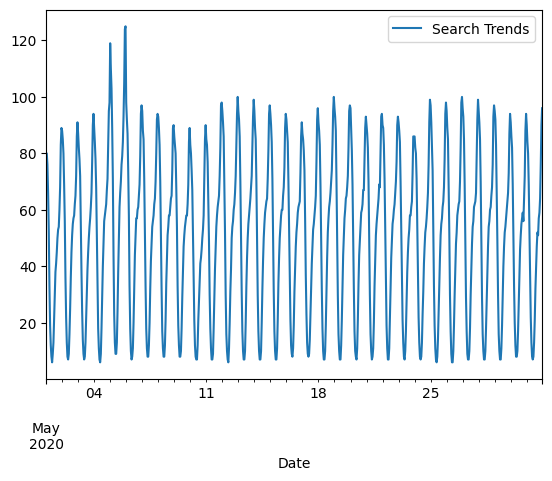

In [6]:
# Plot to visualize the data for May 2020
# Ref 8.1.5
df_may_2020_mercado.plot()

#### Step 2: Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?

In [7]:
# Calculate the sum of the total search traffic for May 2020
# Reference: 8.1.5
traffic_may_2020 = df_may_2020_mercado["Search Trends"].sum()

# View the traffic_may_2020 value
print(traffic_may_2020)
df_may_2020_mercado["Search Trends"].dtypes

38181


dtype('int64')

In [8]:
# Calcluate the monhtly median search traffic across all months
# Group the DataFrame by index year and then index month, chain the sum and then the median functions
# Ref: #4 & 8.2.1
summed_monthly_traffic = df_mercado_trends.groupby([df_mercado_trends.index.year, df_mercado_trends.index.month])['Search Trends'].sum()
median = summed_monthly_traffic.median()
median_monthly_traffic = pd.Series(median, index=["Search Trends"])
# View the median_monthly_traffic value
median_monthly_traffic

Search Trends    35172.5
dtype: float64

In [9]:
# Compare the seach traffic for the month of May 2020 to the overall monthly median value
traffic_may_2020/median_monthly_traffic

Search Trends    1.085536
dtype: float64

##### Answer the following question:

**Question:** Did the Google search traffic increase during the month that MercadoLibre released its financial results?

**Answer:** They did increase. In the month of May (specifically May, 2020, and when MercadoLibre released it's financial results), the total search traffic was **38181**. Compared to the monthly medium calculated across all months, **35172.5**, there was an increase of **.085536**, or about a 9% increase.

## Step 2: Mine the Search Traffic Data for Seasonality

Marketing realizes that they can use the hourly search data, too. If they can track and predict interest in the company and its platform for any time of day, they can focus their marketing efforts around the times that have the most traffic. This will get a greater return on investment (ROI) from their marketing budget.

To that end, you want to mine the search traffic data for predictable seasonal patterns of interest in the company. To do so, complete the following steps:

1. Group the hourly search data to plot the average traffic by the hour of day. Does the search traffic peak at a particular time of day or is it relatively consistent?
>Answer:
>The lowest point of hourly search traffic would be early in the morning, around 5:00/6:00 a.m., while the peaks start to begin their increase at around (10:00 a.m.). The particular time of the highest peak is midnight (00:00:00).

2. Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday). Does the search traffic get busiest on any particular day of the week?
>Answer:
> The traffic is relatively high at the begining of the week, with the highest point on Tuesday. It tapers off and drastically decreases moving into the weekend, where it hits it's lowest point.

3. Group the hourly search data to plot the average traffic by the week of the year. Does the search traffic tend to increase during the winter holiday period (weeks 40 through 52)?
>Answer:
>I would say that yes, the search traffic does increase during the holiday week period. At the end (of week 52), it drops down, only to most likely spike back up again in the following weeks. It absolutely hits it's peak for holiday season right before a major holiday, Christmas (about weeks 49-52).


#### Step 1: Group the hourly search data to plot the average traffic by the hour of the day.

In [10]:
# Double checking datetime format (although, it was read in this way)
df_mercado_trends.index = pd.to_datetime(df_mercado_trends.index)
df_mercado_trends.head()

,Search Trends
Date,
2016-06-01 00:00:00,97
2016-06-01 01:00:00,92
2016-06-01 02:00:00,76
2016-06-01 03:00:00,60
2016-06-01 04:00:00,38


<Axes: xlabel='Date'>

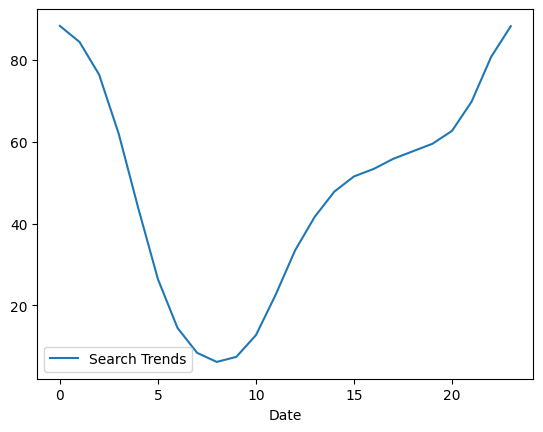

In [11]:
# Group the hourly search data to plot the average traffic by the day of week, using `df.index.hour`
# Ref: 8.2.6
# The x-axis being labeled 'Date' is a little confusing, although that is how it is structered in the dataframe (the index)
# The below commented out line is what I first tried, but decided I could simplify it to mirror the desired output
# average_traffic_by_hour = df_mercado_trends.groupby(df_mercado_trends.index.hour).mean().plot()
df_mercado_trends.groupby(df_mercado_trends.index.hour).mean().plot()

#### Step 2: Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday).

<Axes: xlabel='day'>

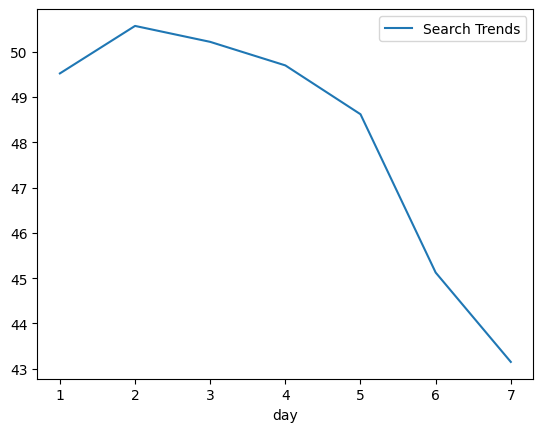

In [12]:
# Group the hourly search data to plot the average traffic by the day of week, using `df.index.isocalendar().day`.
# Applying the same rationale used above for the below code, using df.index.isocalendar().day
df_mercado_trends.groupby(df_mercado_trends.index.isocalendar().day).mean().plot()

#### Step 3: Group the hourly search data to plot the average traffic by the week of the year.

<Axes: xlabel='week'>

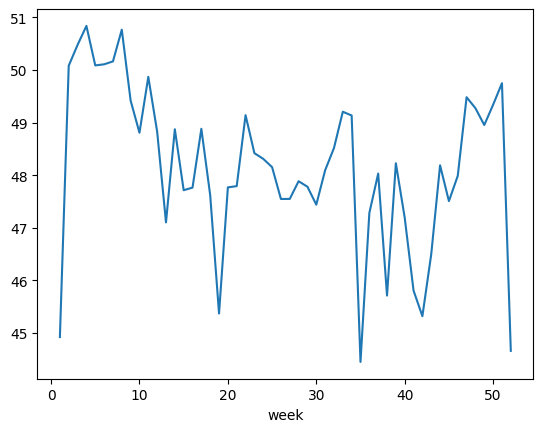

In [13]:
# Group the hourly search data to plot the average traffic by the week of the year using `df.index.isocalendar().week`.
# Once again building off of the above code, including now the search trends column
df_mercado_trends.groupby(df_mercado_trends.index.isocalendar().week).mean()['Search Trends'].plot()

##### Answer the following question:

**Question:** Are there any time based trends that you can see in the data?

**Answer:**
* As I stated above, it appears that a time-based trend would be late-night (any time after 8:00 p.m.) to around midnight, that we can see hourly search traffic at it's highest point.
* Weekly, we see major highs at the beginning of each week (Monday-Friday), and a drastic decrease going into, and throughout, the weekend.
* Annual data by week gives us insight into the trends spiking in the holiday season weeks (40-52), which is just below the highest search data weeks of the year, weeks 2 to (about) 8 in the year. Maybe this would reflect gift return season after receiving possibly unwanted holiday gifts?

## Step 3: Relate the Search Traffic to Stock Price Patterns

You mention your work on the search traffic data during a meeting with people in the finance group at the company. They want to know if any relationship between the search data and the company stock price exists, and they ask if you can investigate.

To do so, complete the following steps:

1. Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

2. Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

3. Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

    * “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

    * “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis

4. Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?


#### Step 1: Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

In [14]:
# Upload the "mercado_stock_price.csv" file into Colab, then store in a Pandas DataFrame
# Set the "date" column as the Datetime Index.
# The link below directly uploads the mercado_stock_price.csv file (when using Colab) and converts it into a dataframe.
df_mercado_stock = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/mercado_stock_price.csv",
    index_col="date",
    parse_dates=True
).dropna()

# View the first and last five rows of the DataFrame
display(df_mercado_stock.head())
display(df_mercado_stock.tail())

,close
date,
2015-01-02 09:00:00,127.67
2015-01-02 10:00:00,125.44
2015-01-02 11:00:00,125.57
2015-01-02 12:00:00,125.40
2015-01-02 13:00:00,125.17


,close
date,
2020-07-31 11:00:00,1105.780
2020-07-31 12:00:00,1087.925
2020-07-31 13:00:00,1095.800
2020-07-31 14:00:00,1110.650
2020-07-31 15:00:00,1122.510


<Axes: xlabel='date'>

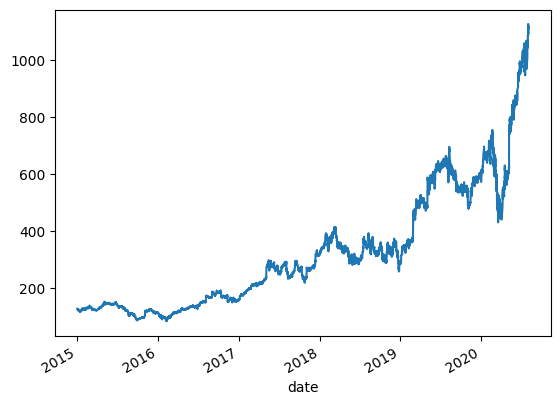

In [15]:
# Visualize the closing price of the df_mercado_stock DataFrame
# Ref: 8.2.3
df_mercado_stock['close'].plot()

In [16]:
# Concatenate the df_mercado_stock DataFrame with the df_mercado_trends DataFrame
# Concatenate the DataFrame by columns (axis=1), and drop and rows with only one column of data
# Ref: 8.2.3
mercado_stock_trends_df = pd.concat([df_mercado_stock, df_mercado_trends], axis=1).dropna()

# View the first rows of the DataFrame
# Alternatively, I could use display(combined_df.head(), and display(combined_df.tail() to diplay both in one output
# The concatenated dataframe now displays two columns (in addition to the datetime index), 'close' and 'Search Trends'
mercado_stock_trends_df.head()

,close,Search Trends
2016-06-01 09:00:00,135.16,6.0
2016-06-01 10:00:00,136.63,12.0
2016-06-01 11:00:00,136.56,22.0
2016-06-01 12:00:00,136.42,33.0
2016-06-01 13:00:00,136.10,40.0


In [17]:
# View the last rows of the DataFrame
mercado_stock_trends_df.tail()

,close,Search Trends
2020-07-31 11:00:00,1105.780,20.0
2020-07-31 12:00:00,1087.925,32.0
2020-07-31 13:00:00,1095.800,41.0
2020-07-31 14:00:00,1110.650,47.0
2020-07-31 15:00:00,1122.510,53.0


#### Step 2: Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

In [18]:
# For the combined dataframe, slice to just the first half of 2020 (2020-01 through 2020-06)
# Ref: 8.1.3
first_half_2020 = mercado_stock_trends_df.loc['2020-01-01':'2020-06-30']
# View the first and last five rows of first_half_2020 DataFrame
# I flipped the display from the above step, to show it is possible both ways (either with or without display)
display(first_half_2020.head())
display(first_half_2020.tail())

,close,Search Trends
2020-01-02 09:00:00,601.085,9.0
2020-01-02 10:00:00,601.290,14.0
2020-01-02 11:00:00,615.410,25.0
2020-01-02 12:00:00,611.400,37.0
2020-01-02 13:00:00,611.830,50.0


,close,Search Trends
2020-06-30 11:00:00,976.17,17.0
2020-06-30 12:00:00,977.50,27.0
2020-06-30 13:00:00,973.23,37.0
2020-06-30 14:00:00,976.50,45.0
2020-06-30 15:00:00,984.93,51.0


array([<Axes: >, <Axes: >], dtype=object)

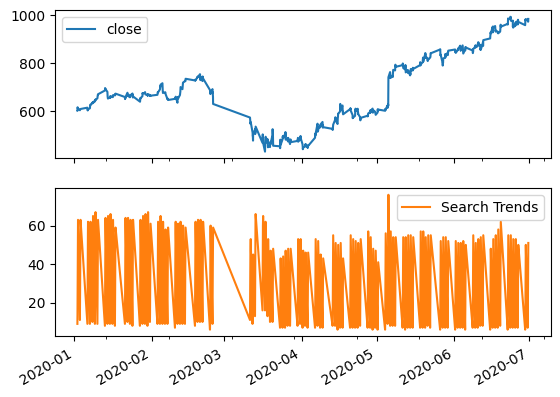

In [19]:
# Visualize the close and Search Trends data
# Plot each column on a separate axes using the following syntax
# `plot(subplots=True)`
# Ref: #5
first_half_2020.plot(subplots=True)

##### Answer the following question:

**Question:** Do both time series indicate a common trend that’s consistent with this narrative?

**Answer:** The two plots are rather similar, with similar drops during the month of March. The search trends follow and normal path until May, when the report is released. The closing patterns of the stock data slowly rise until May, where they begin to increase at a rapid rate. These differ slightly, as the 'Search Trends' hit their peak in May, but return to their normal pattern thereafter. The stock closing data peaks in May, but continue to rise for the remainder of this half of the year.

#### Step 3: Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

* “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

* “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis


In [20]:
# Create a new column in the mercado_stock_trends_df DataFrame called Lagged Search Trends
# This column should shift the Search Trends information by one hour
# Ref: 8.2.3
mercado_stock_trends_df['Lagged Search Trends'] = mercado_stock_trends_df['Search Trends'].shift(1)
display(mercado_stock_trends_df.head())

,close,Search Trends,Lagged Search Trends
2016-06-01 09:00:00,135.16,6.0,NaN
2016-06-01 10:00:00,136.63,12.0,6.0
2016-06-01 11:00:00,136.56,22.0,12.0
2016-06-01 12:00:00,136.42,33.0,22.0
2016-06-01 13:00:00,136.10,40.0,33.0


In [21]:
# Create a new column in the mercado_stock_trends_df DataFrame called Stock Volatility
# This column should calculate the standard deviation of the closing stock price return data over a 4 period rolling window
# window=4 for the 4 periods
# Ref: 8.2.3
mercado_stock_trends_df['Stock Volatility'] = mercado_stock_trends_df['close'].pct_change().rolling(window=4).std()
display(mercado_stock_trends_df.head())

,close,Search Trends,Lagged Search Trends,Stock Volatility
2016-06-01 09:00:00,135.16,6.0,NaN,NaN
2016-06-01 10:00:00,136.63,12.0,6.0,NaN
2016-06-01 11:00:00,136.56,22.0,12.0,NaN
2016-06-01 12:00:00,136.42,33.0,22.0,NaN
2016-06-01 13:00:00,136.10,40.0,33.0,0.006134


<Axes: >

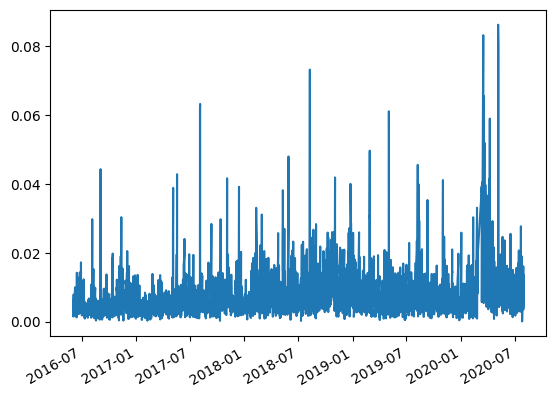

In [22]:
# Visualize the stock volatility
# mercado_stock_trends_df.plot() - This would plot the entire dataframe, but I only want to visualize the...
# ...stock volatility (to match the desired plot output)
mercado_stock_trends_df['Stock Volatility'].plot()

**Solution Note:** Note how volatility spiked, and tended to stay high, during the first half of 2020. This is a common characteristic of volatility in stock returns worldwide: high volatility days tend to be followed by yet more high volatility days. When it rains, it pours.

In [23]:
# Create a new column in the mercado_stock_trends_df DataFrame called Hourly Stock Return
# This column should calculate hourly return percentage of the closing price
# If I wanted the actual percentage conversion, I could add *100 at the end of the line.
# Ref: 8.2.3 and #6
mercado_stock_trends_df['Hourly Stock Return'] = mercado_stock_trends_df['close'].pct_change()

In [24]:
# View the first and last five rows of the mercado_stock_trends_df DataFrame
display(mercado_stock_trends_df.head())
display(mercado_stock_trends_df.tail())

,close,Search Trends,Lagged Search Trends,Stock Volatility,Hourly Stock Return
2016-06-01 09:00:00,135.16,6.0,NaN,NaN,NaN
2016-06-01 10:00:00,136.63,12.0,6.0,NaN,0.010876
2016-06-01 11:00:00,136.56,22.0,12.0,NaN,-0.000512
2016-06-01 12:00:00,136.42,33.0,22.0,NaN,-0.001025
2016-06-01 13:00:00,136.10,40.0,33.0,0.006134,-0.002346


,close,Search Trends,Lagged Search Trends,Stock Volatility,Hourly Stock Return
2020-07-31 11:00:00,1105.780,20.0,11.0,0.012837,0.006380
2020-07-31 12:00:00,1087.925,32.0,20.0,0.013549,-0.016147
2020-07-31 13:00:00,1095.800,41.0,32.0,0.013295,0.007239
2020-07-31 14:00:00,1110.650,47.0,41.0,0.013001,0.013552
2020-07-31 15:00:00,1122.510,53.0,47.0,0.013566,0.010678


#### Step 4: Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

In [25]:
# Construct correlation table of Stock Volatility, Lagged Search Trends, and Hourly Stock Return
# Ref 8.2.3, although this code was already provided.
mercado_stock_trends_df[['Stock Volatility', 'Lagged Search Trends', 'Hourly Stock Return']].corr()

,Stock Volatility,Lagged Search Trends,Hourly Stock Return
Stock Volatility,1.000000,-0.148938,0.061424
Lagged Search Trends,-0.148938,1.000000,0.017929
Hourly Stock Return,0.061424,0.017929,1.000000


##### Answer the following question:


**Question:** Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

**Answer:** Ref: #7 and #8
* The correlation between the lagged search traffic (`Lagged Search Trends`) and stock volatility (`Stock Volatility`) is rather weak. In fact, it has a negative correlation (-0.148938). This would make any further predictions between the two, based on this data alone, not incredibly helpful or useful.
* Between lagged search traffic (`Lagged Search Trends`) and stock price returns (`Hourly Stock Return`), it would also appear that their relationship is also very weak. However, it is good to mention that there is a slightly positive relationship between the two (0.017929). Meaning, the hourly stock change prices do not necessarily have much predictable influence on how volatile the stock may be.
* To conclude, the three factors, that I have data for, do not appear to directly influence each other in a meaningful way. The numbers do not appear to display any predictable relationships.


## Step 4: Create a Time Series Model with Prophet

Now, you need to produce a time series model that analyzes and forecasts patterns in the hourly search data. To do so, complete the following steps:

1. Set up the Google search data for a Prophet forecasting model.

2. After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

3. Plot the individual time series components of the model to answer the following questions:

    * What time of day exhibits the greatest popularity?

    * Which day of the week gets the most search traffic?

    * What's the lowest point for search traffic in the calendar year?

### **Answers** are provided at the conclusion of Step 2's cells.

#### Step 1: Set up the Google search data for a Prophet forecasting model.

In [26]:
# Using the df_mercado_trends DataFrame, reset the index so the date information is no longer the index
# Ref 8.2.6
prophet_df = df_mercado_trends.reset_index()

# Label the columns ds and y so that the syntax is recognized by Prophet
prophet_df.columns = ['ds', 'y']

# Drop an NaN values from the prophet_df DataFrame
mercado_prophet_df = prophet_df.dropna()

# View the first and last five rows of the mercado_prophet_df DataFrame
display(mercado_prophet_df.head())
display(mercado_prophet_df.tail())

,ds,y
0,2016-06-01 00:00:00,97
1,2016-06-01 01:00:00,92
2,2016-06-01 02:00:00,76
3,2016-06-01 03:00:00,60
4,2016-06-01 04:00:00,38


,ds,y
37101,2020-09-07 20:00:00,71
37102,2020-09-07 21:00:00,83
37103,2020-09-07 22:00:00,96
37104,2020-09-07 23:00:00,97
37105,2020-09-08 00:00:00,96


In [27]:
# Call the Prophet function, store as an object
# Ref: 8.3.3
m = Prophet()
m

In [28]:
# Fit the time-series model.
# Ref: 8.3.3
m.fit(prophet_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpldycljv1/l29ud7nl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpldycljv1/bx15b1ko.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24515', 'data', 'file=/tmp/tmpldycljv1/l29ud7nl.json', 'init=/tmp/tmpldycljv1/bx15b1ko.json', 'output', 'file=/tmp/tmpldycljv1/prophet_modelia_uzj01/prophet_model-20240428212947.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:29:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:30:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [29]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as 2000 hours (approx 80 days)
# Ref: 8.3.3
# freq=H for hours, meaning this will understand that periods=2000 represents 2000 hours
future_mercado_trends_2000 = m.make_future_dataframe(periods=2000, freq='H')

# View the last five rows of the future_mercado_trends DataFrame
display(future_mercado_trends_2000.tail())

,ds
39101,2020-11-30 04:00:00
39102,2020-11-30 05:00:00
39103,2020-11-30 06:00:00
39104,2020-11-30 07:00:00
39105,2020-11-30 08:00:00


In [30]:
# Make the predictions for the trend data using the future_mercado_trends DataFrame
# Ref: 8.3.3
forecast_mercado_trends = m.predict(future_mercado_trends_2000)

# Display the first five rows of the forecast_mercado_trends DataFrame
display(forecast_mercado_trends.head())
# A It looks like this prediction is slightly different than the desired output, but that is to be expected!

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-06-01 00:00:00,44.469500,81.403299,97.691852,44.469500,44.469500,45.159722,45.159722,45.159722,41.452703,...,1.860594,1.860594,1.860594,1.846426,1.846426,1.846426,0.0,0.0,0.0,89.629222
1,2016-06-01 01:00:00,44.470406,77.051675,93.811635,44.470406,44.470406,41.605529,41.605529,41.605529,37.943556,...,1.810498,1.810498,1.810498,1.851474,1.851474,1.851474,0.0,0.0,0.0,86.075935
2,2016-06-01 02:00:00,44.471312,67.128193,84.035214,44.471312,44.471312,31.282049,31.282049,31.282049,27.656646,...,1.768912,1.768912,1.768912,1.856491,1.856491,1.856491,0.0,0.0,0.0,75.753361
3,2016-06-01 03:00:00,44.472218,51.830431,69.270181,44.472218,44.472218,16.014826,16.014826,16.014826,12.417424,...,1.735926,1.735926,1.735926,1.861476,1.861476,1.861476,0.0,0.0,0.0,60.487045
4,2016-06-01 04:00:00,44.473124,35.222440,51.339419,44.473124,44.473124,-1.100073,-1.100073,-1.100073,-4.677999,...,1.711496,1.711496,1.711496,1.866430,1.866430,1.866430,0.0,0.0,0.0,43.373051


#### Step 2: After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

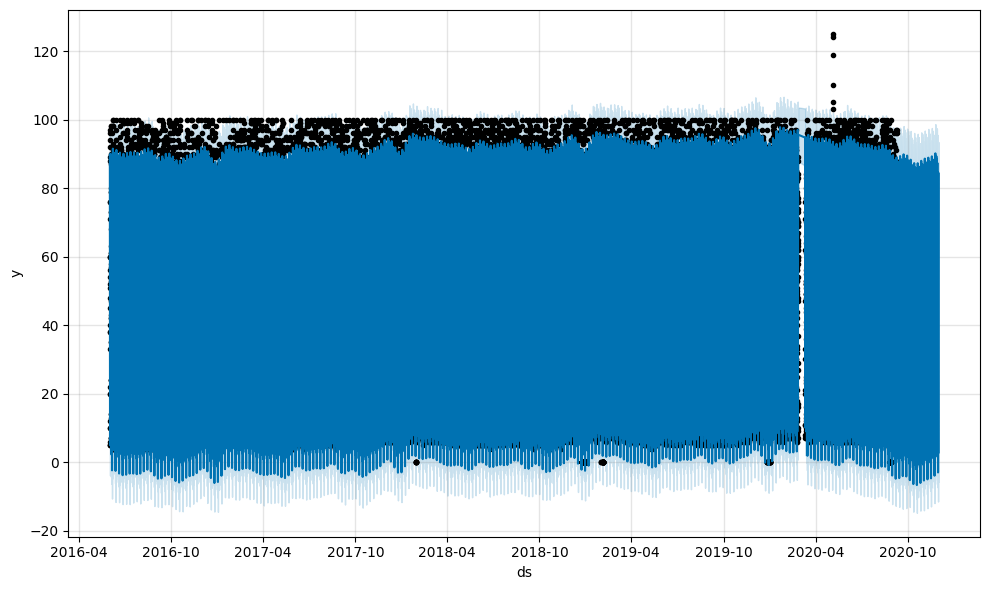

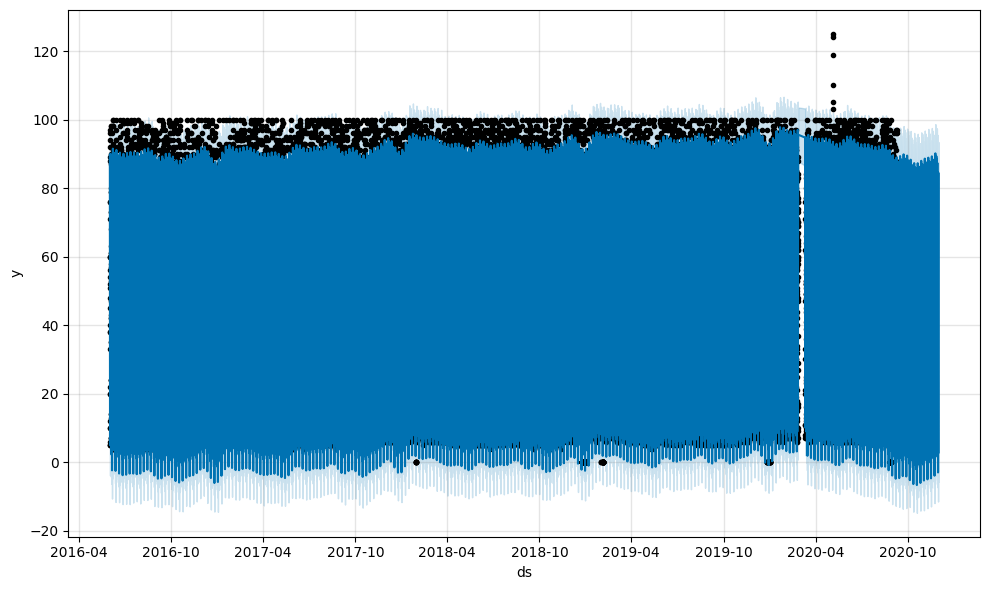

In [31]:
# Plot the Prophet predictions for the Mercado trends data
# Ref: 8.3.3
m.plot(forecast_mercado_trends)

##### Answer the following question:

**Question:**  How's the near-term forecast for the popularity of MercadoLibre?

**Answer:** Ref #9
* The declining `yhat` values would indicate a **decrease** in forecasted popularity. If they were rising, it would be indicative of an increase in popularity of the near-term forecast.


#### Step 3: Plot the individual time series components of the model to answer the following questions:

* What time of day exhibits the greatest popularity?

* Which day of the week gets the most search traffic?

* What's the lowest point for search traffic in the calendar year?

### **Answers** are provided at the conclusion of the notebook.

In [32]:
# Set the index in the forecast_mercado_trends DataFrame to the ds datetime column
# Ref: 8.3.3 and 8.3.5
# ascending=True
forecast_mercado_trends = forecast_mercado_trends.set_index('ds')

# View the only the yhat,yhat_lower and yhat_upper columns from the DataFrame
display(forecast_mercado_trends[['yhat', 'yhat_lower', 'yhat_upper']].head())

,yhat,yhat_lower,yhat_upper
ds,,,
2016-06-01 00:00:00,89.629222,81.403299,97.691852
2016-06-01 01:00:00,86.075935,77.051675,93.811635
2016-06-01 02:00:00,75.753361,67.128193,84.035214
2016-06-01 03:00:00,60.487045,51.830431,69.270181
2016-06-01 04:00:00,43.373051,35.222440,51.339419


In [33]:
# From the forecast_mercado_trends DataFrame, plot the data to visualize
#  the yhat, yhat_lower, and yhat_upper columns over the last 2000 hours
# Ref: 8.3.3 and 8.3.5

In [34]:
# Slicing the dataframe to obtain only the last (tail) 2000 hours
forecast_last_2000_hours = forecast_mercado_trends.tail(2000)
forecast_mercado_trends_2000 = forecast_last_2000_hours[['yhat', 'yhat_lower', 'yhat_upper']]

In [35]:
# Peak at the dataframe for the last 2000 hours (beginning and end)
display(forecast_mercado_trends_2000.head())
display(forecast_mercado_trends_2000.tail())

,yhat,yhat_lower,yhat_upper
ds,,,
2020-09-08 01:00:00,85.527749,77.449621,94.176020
2020-09-08 02:00:00,75.275577,66.828465,83.865988
2020-09-08 03:00:00,60.052505,50.964013,67.969522
2020-09-08 04:00:00,42.955705,34.656726,51.204790
2020-09-08 05:00:00,27.101529,18.856379,35.315877


,yhat,yhat_lower,yhat_upper
ds,,,
2020-11-30 04:00:00,39.781638,31.250637,48.434122
2020-11-30 05:00:00,24.310504,16.194911,32.744526
2020-11-30 06:00:00,12.344836,3.775559,20.985058
2020-11-30 07:00:00,5.072692,-3.531630,13.710263
2020-11-30 08:00:00,2.877820,-5.690197,10.772241


Solutions Note: `yhat` represents the most likely (average) forecast, whereas `yhat_lower` and `yhat_upper` represents the worst and best case prediction (based on what are known as 95% confidence intervals).

<Axes: xlabel='ds'>

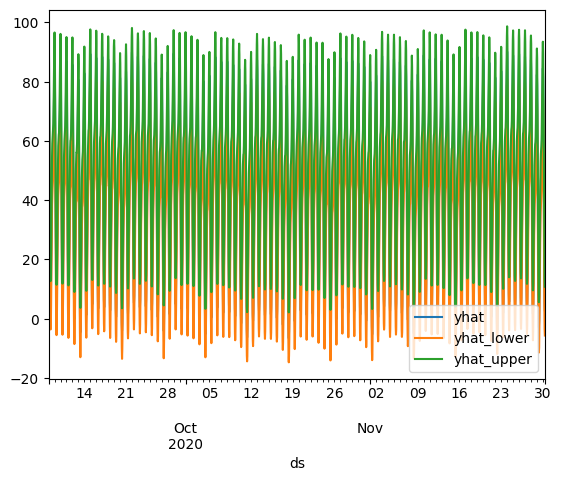

In [36]:
# From the forecast_mercado_trends DataFrame, plot the data to visualize
#  the yhat, yhat_lower, and yhat_upper columns over the last 2000 hours
# Ref: 8.2.7
forecast_mercado_trends_2000.plot()

In [37]:
# Reset the index in the forecast_mercado_trends DataFrame
# Ref 8.3.3
# First, check the current format of the dataframe to ensure resetting the index is necessary
# The below dataframe should display as having 'ds' as the index, confirming an index reset is needed
forecast_mercado_trends.head()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,,,,
2016-06-01 00:00:00,44.469500,81.403299,97.691852,44.469500,44.469500,45.159722,45.159722,45.159722,41.452703,41.452703,...,1.860594,1.860594,1.860594,1.846426,1.846426,1.846426,0.0,0.0,0.0,89.629222
2016-06-01 01:00:00,44.470406,77.051675,93.811635,44.470406,44.470406,41.605529,41.605529,41.605529,37.943556,37.943556,...,1.810498,1.810498,1.810498,1.851474,1.851474,1.851474,0.0,0.0,0.0,86.075935
2016-06-01 02:00:00,44.471312,67.128193,84.035214,44.471312,44.471312,31.282049,31.282049,31.282049,27.656646,27.656646,...,1.768912,1.768912,1.768912,1.856491,1.856491,1.856491,0.0,0.0,0.0,75.753361
2016-06-01 03:00:00,44.472218,51.830431,69.270181,44.472218,44.472218,16.014826,16.014826,16.014826,12.417424,12.417424,...,1.735926,1.735926,1.735926,1.861476,1.861476,1.861476,0.0,0.0,0.0,60.487045
2016-06-01 04:00:00,44.473124,35.222440,51.339419,44.473124,44.473124,-1.100073,-1.100073,-1.100073,-4.677999,-4.677999,...,1.711496,1.711496,1.711496,1.866430,1.866430,1.866430,0.0,0.0,0.0,43.373051


In [38]:
# Reset the index
# Ref 8.3.3
forecast_mercado_trends_index_reset = forecast_mercado_trends.reset_index(drop=False)
forecast_mercado_trends_index_reset.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-06-01 00:00:00,44.469500,81.403299,97.691852,44.469500,44.469500,45.159722,45.159722,45.159722,41.452703,...,1.860594,1.860594,1.860594,1.846426,1.846426,1.846426,0.0,0.0,0.0,89.629222
1,2016-06-01 01:00:00,44.470406,77.051675,93.811635,44.470406,44.470406,41.605529,41.605529,41.605529,37.943556,...,1.810498,1.810498,1.810498,1.851474,1.851474,1.851474,0.0,0.0,0.0,86.075935
2,2016-06-01 02:00:00,44.471312,67.128193,84.035214,44.471312,44.471312,31.282049,31.282049,31.282049,27.656646,...,1.768912,1.768912,1.768912,1.856491,1.856491,1.856491,0.0,0.0,0.0,75.753361
3,2016-06-01 03:00:00,44.472218,51.830431,69.270181,44.472218,44.472218,16.014826,16.014826,16.014826,12.417424,...,1.735926,1.735926,1.735926,1.861476,1.861476,1.861476,0.0,0.0,0.0,60.487045
4,2016-06-01 04:00:00,44.473124,35.222440,51.339419,44.473124,44.473124,-1.100073,-1.100073,-1.100073,-4.677999,...,1.711496,1.711496,1.711496,1.866430,1.866430,1.866430,0.0,0.0,0.0,43.373051


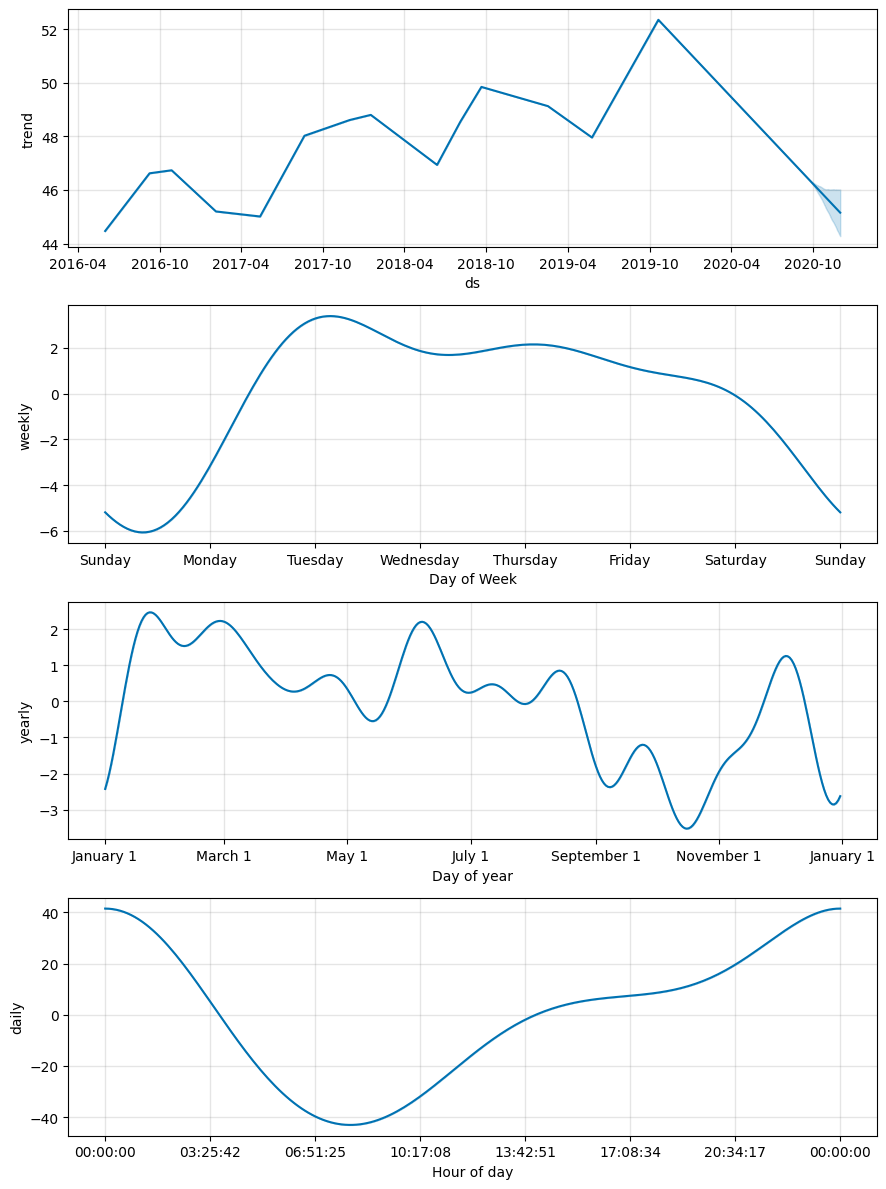

In [39]:
# Use the plot_components function to visualize the forecast results
# for the forecast_canada DataFrame
# ^forecast_canada DataFrame?
# Ref 8.3.3
# Using fig2, as this is what is used in the above reference activity

fig2 = m.plot_components(forecast_mercado_trends_index_reset)

##### Answer the following questions:

**Question:** What time of day exhibits the greatest popularity?

**Answer:** The hour of the greatest popularity is **Midnight/12:00 a.m./00:00:00**

**Question:** Which day of week gets the most search traffic?
   
**Answer:** **Tuesday** holds title for the most search traffic when comparing to other days of the week

**Question:** What's the lowest point for search traffic in the calendar year?

**Answer:** **October** is the lowest point for search traffic in the calendar year (the plot dips between Sepetember 1 and November 1).
